# Instrument recognition in musical audio signals
Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger

## Setup

In [462]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

In [463]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

## Data

The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).


The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

Source: https://www.upf.edu/web/mtg/irmas

### Loading the data
For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. In this project it is used for loading .wav files,  extracting features and visualizations.

## Analysis of data

### Instrument class balance

In [464]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
#class_dirs.remove('.DS_Store')
#class_dirs.remove('README.txt')
class_dirs

['pia',
 'voi',
 '.DS_Store',
 'tru',
 'sax',
 'org',
 'cla',
 'gac',
 'vio',
 'flu',
 'README.txt',
 'gel',
 'cel']

This project uses the following instruments: 

In [465]:
Instruments = sorted(['vio', 'pia', 'org', 'gel', 'gac', 'voi'])
Instruments

['gac', 'gel', 'org', 'pia', 'vio', 'voi']

The plot shows that the the numbers of samples per instrument are not balanced. The instrument with the most samples is **voi** and the instrument with the least samples is **vio**.

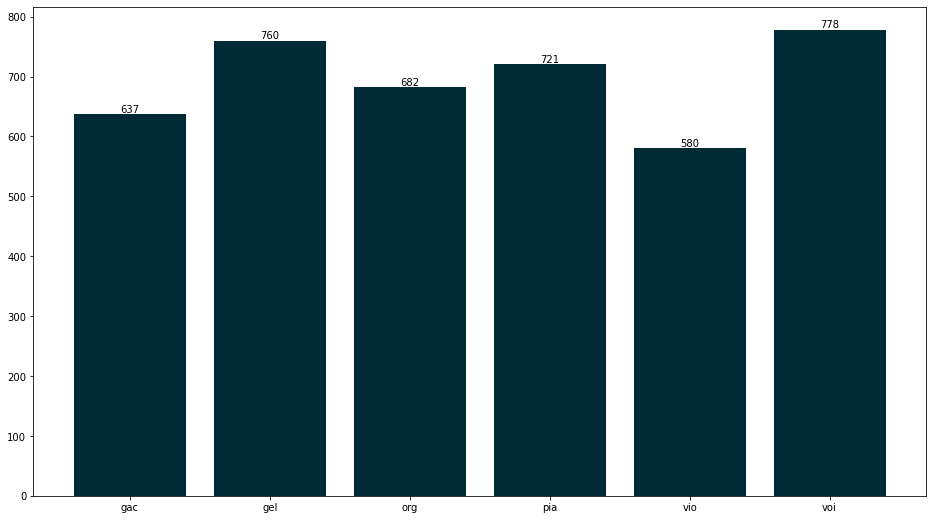

In [466]:
number_of_files = []
for class_name in Instruments:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

fig, ax = plt.subplots()
bars = ax.bar(Instruments, number_of_files, color=pltcolor);
ax.bar_label(bars);

### Example file

In [467]:
y , sr = librosa.load('./IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

**Waveform in the time domain**

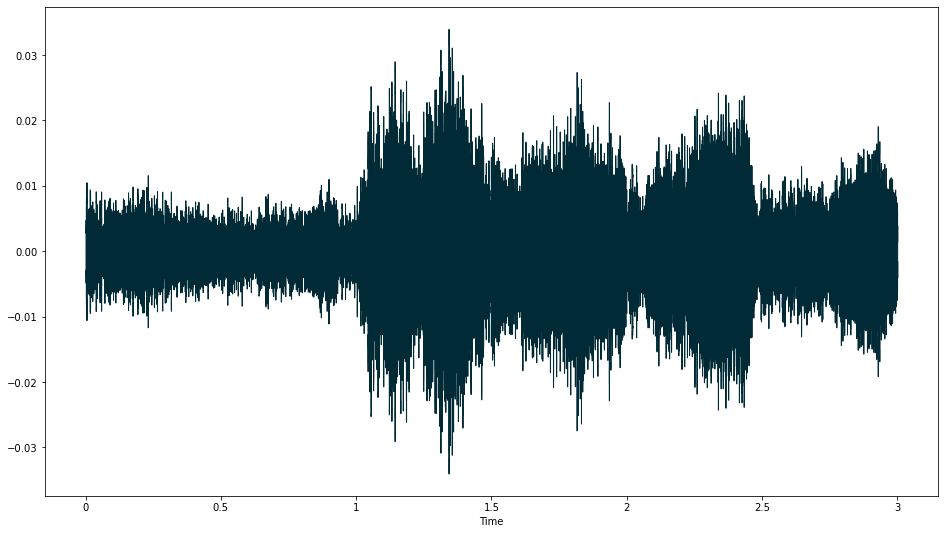

In [468]:
librosa.display.waveshow(y, sr=sr, color=pltcolor);

**Spectrogram**

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.

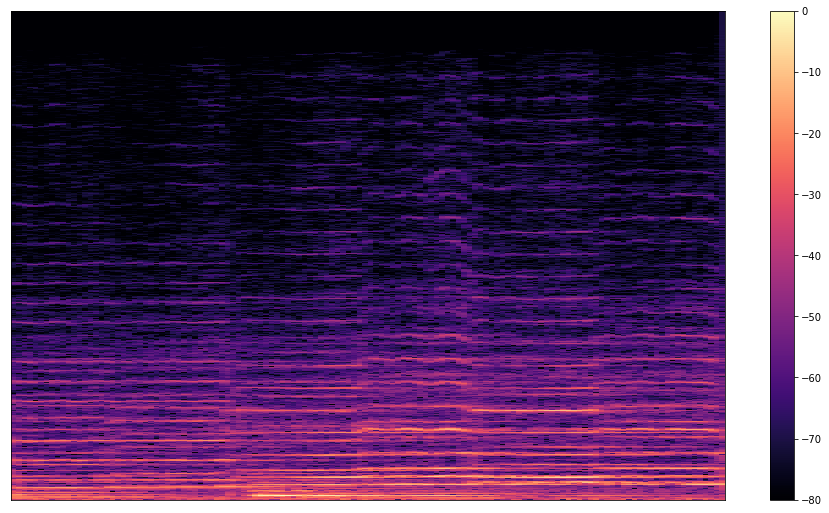

In [469]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(np.abs(stft), ref=np.max) # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar();

## Feature extraction

**Zero Crossing Rate:** the rate at which the signal crosses zero

**Spectral Centroid:** the center of mass in the spectrum

**Spectral Bandwidth:** the weighted average of the frequency signal by its spectrum

**Spectral Roll-Off:** frequency below which a specified percentage of the total spectral energy

In [470]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21): # TODO why 21?
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating a .csv file for storing the data from the music files as extracted features

In [471]:


csv_exists = True

if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)



In [472]:


if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for i in Instruments:
        for filename in os.listdir(f'./IRMAS-TrainingData/{i}'):
            songname = f'./IRMAS-TrainingData/{i}/{filename}'
            y, sr = librosa.load(songname, sr =44100)
            rms = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {i}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [473]:
df = pd.read_csv('data.csv')
df.head()


,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,[vio][jaz_blu]2092__2.wav,0.114771,2008.963579,3413.310309,4315.952280,0.026062,-238.207855,147.416168,19.073757,37.603371,...,8.651993,-2.919450,6.087282,1.375321,3.519054,4.003036,8.993670,14.583170,15.063288,vio
1,[vio][pop_roc]2247__2.wav,0.045145,1904.285733,2847.219346,3232.807221,0.043721,-355.952362,147.138260,-6.634732,24.655594,...,6.055483,-4.204406,11.720703,1.755819,0.502440,-10.289815,-3.562097,-3.135212,-6.306681,vio
2,027__[vio][dru][cou_fol]2189__2.wav,0.257842,3759.639612,3539.671618,7444.252798,0.118622,-37.659492,123.618378,-55.597813,66.752762,...,9.085865,-0.278380,5.583296,1.927523,0.012852,2.059954,-10.427495,-0.631917,-4.914731,vio
3,[vio][cla]2087__1.wav,0.003137,2511.258695,2752.212704,4338.400021,0.068420,-537.393799,126.677574,-69.857018,21.041725,...,-0.073176,-2.393554,19.921106,16.488857,9.842477,1.030309,-4.826866,-4.345613,-0.308287,vio
4,099__[vio][nod][cla]2172__1.wav,0.031447,958.535672,1431.991046,1768.383129,0.021094,-431.933594,203.627762,-24.785480,29.247166,...,-2.118557,-11.496170,-2.753783,1.015238,-1.763513,-3.037489,0.608210,5.419205,-1.962356,vio


## Analysis of features

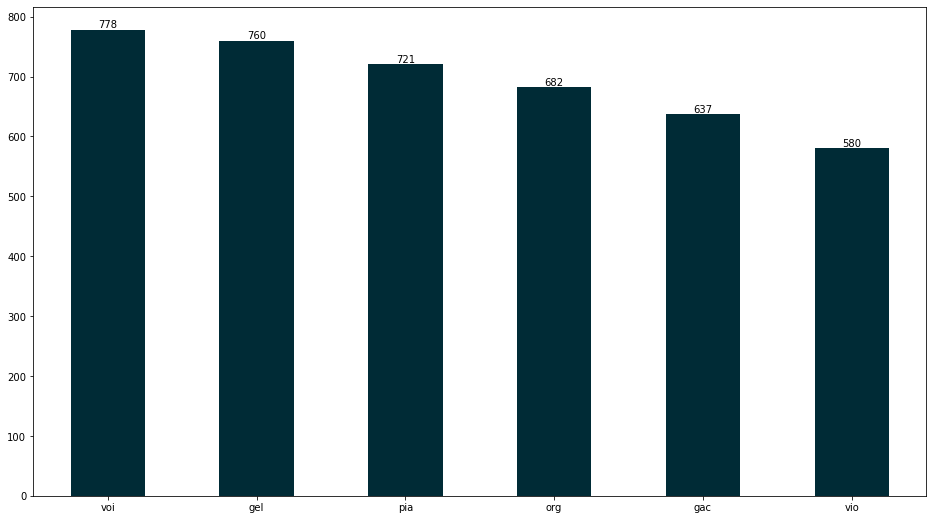

In [474]:
table = df['label'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor);
ax.bar_label(ax.containers[0]);

The class imbalance and the number of samples per instrument are still the same after the feature extraction.

### Correlation between features

The most correlated features are rolloff and spectral_centroid, spectral bandwith and rolloff as well as spectral_centroid and spectral_bandwidth.

In [475]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

mfcc2               spectral_centroid    -0.832009
spectral_bandwidth  mfcc2                -0.820206
rolloff             mfcc2                -0.774466
mfcc2               mfcc4                -0.645317
mfcc6               mfcc2                -0.598631
                                            ...   
spectral_centroid   zero_crossing_rate    0.863322
                    spectral_bandwidth    0.900877
spectral_bandwidth  rolloff               0.932395
spectral_centroid   rolloff               0.965179
rms                 rms                   1.000000
Length: 301, dtype: float64

Highest correlation of 0.967746 between spectral_centroid and rolloff

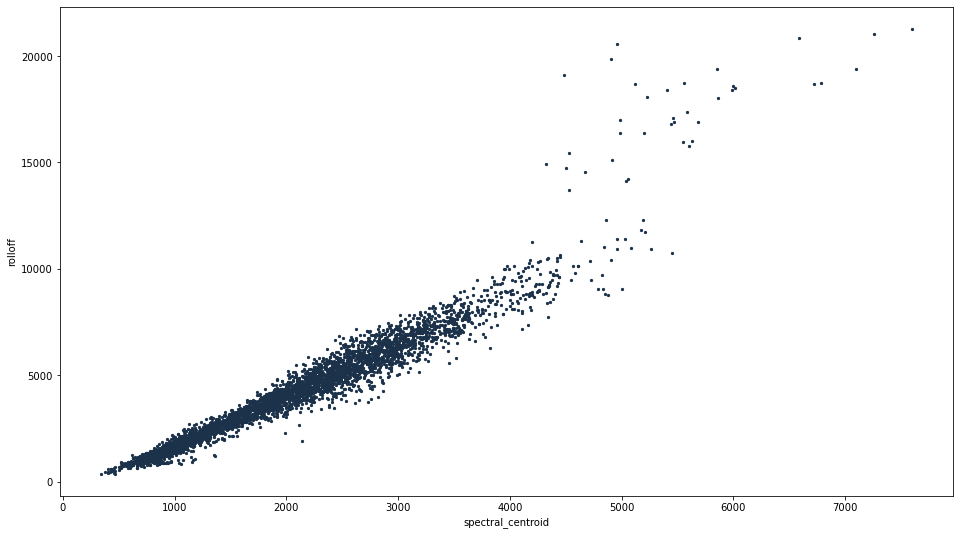

In [476]:
df.plot.scatter("spectral_centroid", "rolloff", c="#1b324a", marker='.');

## Preprocessing

### NaN values

In [477]:
df.isnull().values.any()

False

There are no NaN values in this dataset.

### Outliers

In [478]:
cols = df.columns.tolist()
cols.remove('label')
cols.remove('filename')

for col in cols:
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    intr_qr = q75-q25

    q_hi = q75+(1.5*intr_qr)
    q_low = q25-(1.5*intr_qr)

    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-len(df_filtered))+' rows with outliers removed.')
df = df_filtered


90 rows with outliers removed.


### Scaling

In [479]:
# drop filename from dataframe
df = df.drop(['filename'],axis=1)

In [480]:
# extract instrument labels
instru_list = df.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)
labels = y

df['label'] = y

# uniformly scale data
scaler = StandardScaler()
X_transform = scaler.fit_transform(df.iloc[:, :-1].values)

# save scaler
pickle.dump(scaler, open('./scaler.pkl','wb'))

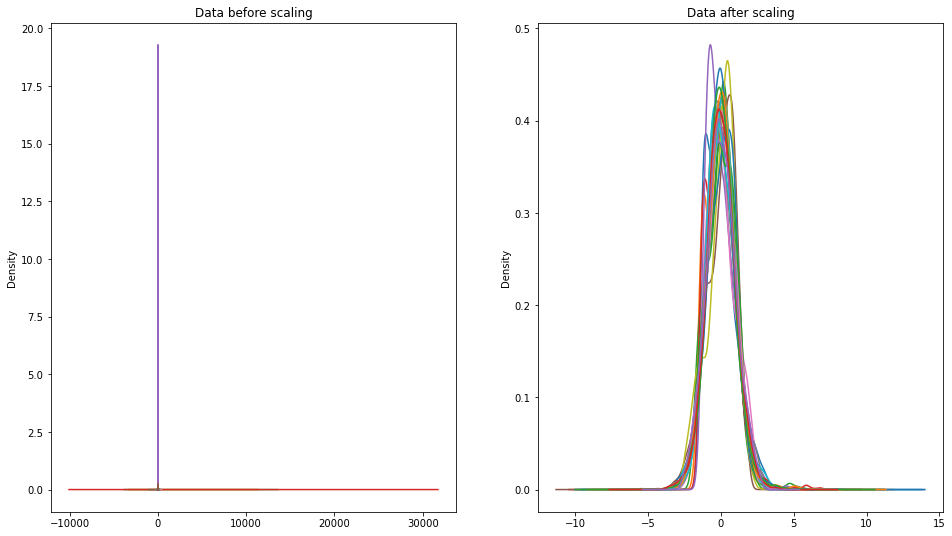

In [481]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False);
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, :-1].columns)
df_scaled.plot.density(ax=ax2, legend=False);

In [482]:
# print labels
print('Numberic values instead of class names: ')
print(y)

Numberic values instead of class names: 
[4 4 4 ... 5 5 5]


### Features

The main feature extraction was already done by extracting the features from the .wav files.

#### Feature reduction with PCA

This plot shows the explained variance ratio when 85% of variance is kept.    
Feature reduction with PCA  wil be applied later when training the models using a pipeline.

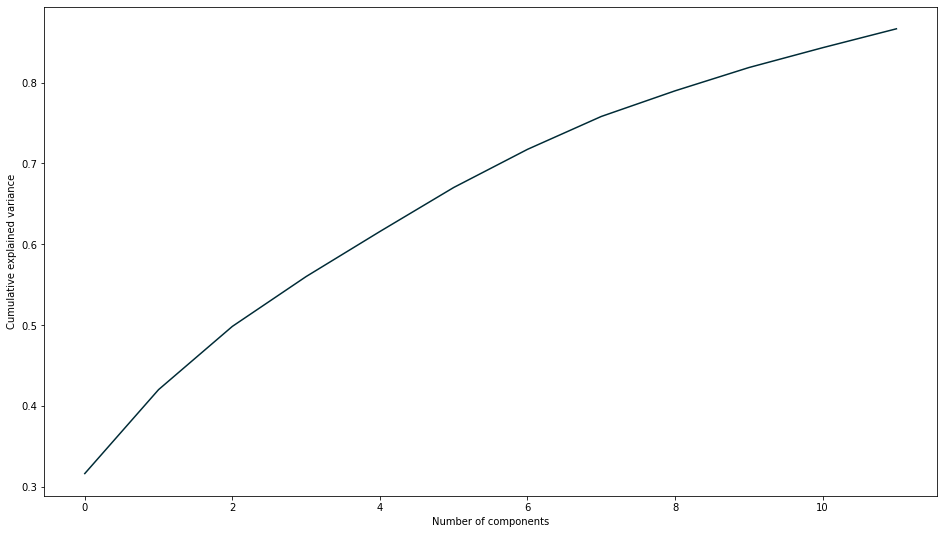

In [483]:
pca = PCA(n_components=0.85)
pca.fit(X_transform)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=pltcolor)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


## Models

In [484]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
1669,0.094614,3027.905217,3622.263329,6753.028663,0.071623,-227.388397,139.549255,2.750967,62.178238,-12.737752,...,9.531472,-4.806884,-6.799053,-9.529763,-8.039477,3.511667,-9.547147,-4.653588,-8.961961,2
270,0.037405,1531.820999,1980.010286,2918.289432,0.036691,-321.096008,189.150024,-35.890774,31.580887,5.750418,...,-6.468444,-2.187094,-1.008750,5.092014,4.233546,5.877126,3.039838,-0.706603,-5.793774,4
3275,0.050270,4479.190788,8018.655407,19124.560547,0.108847,-407.114868,183.841263,74.678711,-3.312003,31.594816,...,-7.136656,5.536606,-11.068748,7.248069,-10.762789,-3.507489,-16.965044,-0.450852,-8.881108,0
125,0.184886,2977.485802,3997.011925,6846.062078,0.051665,-110.726990,126.596298,-6.579250,38.006413,-2.836074,...,14.348186,-6.175253,-6.206351,-20.680656,-11.050307,-8.208455,4.514470,-0.245044,5.133935,4
1174,0.154728,2647.774705,1838.096099,4355.609956,0.095667,-210.739655,135.154617,-109.354553,16.257605,-4.183599,...,-1.596775,10.057726,14.243485,9.425647,10.204681,7.420058,6.385778,-1.427300,0.420497,3


Test data with all features

In [485]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2)

### SVM Model

In [486]:
tuning_params_svm={"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1, 10], "kernel": ['rbf']}
param_grid_svm = {}

for key,value in tuning_params_svm.items():
    hyperparam_key = "classify__" + key
    param_grid_svm[hyperparam_key] = value

#### SVM with all features

In [487]:
pipe = Pipeline([
        ('classify', SVC())
])

gs = GridSearchCV(pipe, param_grid=param_grid_svm, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [488]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 10, 'classify__gamma': 0.1, 'classify__kernel': 'rbf'}
Best balanced accuracy score: 0.7615245019557231


Recall:  [0.84033613 0.78807947 0.82706767 0.72932331 0.6728972  0.71345029]
Recall Average:  0.7616707616707616
Precision:  [0.74074074 0.7345679  0.83333333 0.78861789 0.66666667 0.79220779]
Precision Average:  0.7616707616707616
F1-Score:  [0.78740157 0.76038339 0.83018868 0.7578125  0.66976744 0.75076923]
Balanced Accuracy: 0.76  , 0.7618590117925681
Accuracy: 0.76  , 620
Number of samples: 814


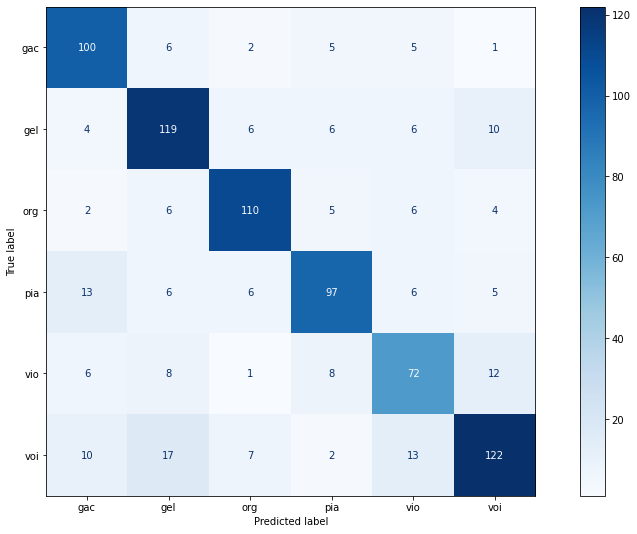

In [489]:
predicted_labels = gs.best_estimator_.predict(X_test)
predicted_labels_svm = predicted_labels

svm_model = gs.best_estimator_

# save model
pickle.dump(svm_model, open('./model.pkl', 'wb'))


print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


#### SVM with PCA

In [490]:
pipe = Pipeline([
        ('normalization', StandardScaler()),
        ('pca', PCA(n_components=0.85)), 
        ('classify', SVC())
])

gs = GridSearchCV(pipe, param_grid=param_grid_svm, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [491]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))
print('Best estimator explained variance: '+str(gs.best_estimator_.steps[1][1].explained_variance_))

Best parameters: {'classify__C': 10, 'classify__gamma': 0.1, 'classify__kernel': 'rbf'}
Best balanced accuracy score: 0.6537861133712827
Best estimator explained variance: [7.90382561 2.56033086 1.96016412 1.58903288 1.43190959 1.35675322
 1.16214307 1.00763556 0.7958903  0.73952889 0.6228244  0.584781  ]


Recall:  [0.75630252 0.66225166 0.60150376 0.63909774 0.56074766 0.55555556]
Recall Average:  0.6265356265356266
Precision:  [0.703125   0.59171598 0.61538462 0.63432836 0.65217391 0.59006211]
Precision Average:  0.6265356265356266
F1-Score:  [0.72874494 0.625      0.60836502 0.63670412 0.60301508 0.57228916]
Balanced Accuracy: 0.63  , 0.6292431499173164
Balanced Accuracy: 0.63  , 0.6292431499173164
Accuracy: 0.63  , 510
Number of samples: 814


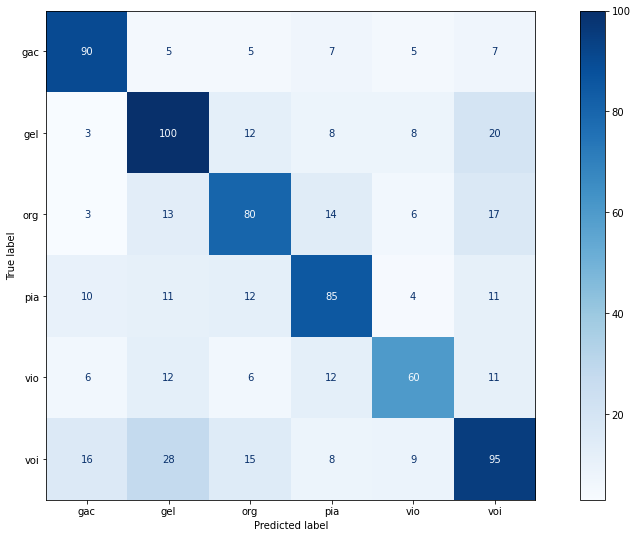

In [492]:
predicted_labels = gs.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels, average=None))
print("Recall Average: ", recall_score(
    y_test, predicted_labels, average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels, average=None))
print("Precision Average: ", precision_score(
    y_test, predicted_labels, average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(
    y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(
    y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,
      normalize=True), accuracy_score(y_test, predicted_labels, normalize=False))

print("Number of samples:", y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(
    y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues")


### KNN

In [493]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, 31)))
  
# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='balanced_accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

accuracy = grid_search.best_score_ *100
print("Best params: "+str(grid_search.best_params_))
print("Balanced accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'n_neighbors': 1}
Balanced accuracy for our training dataset with tuning is : 75.97%


Recall:  [0.80672269 0.81456954 0.79699248 0.79699248 0.6728972  0.71345029]
Recall Average:  0.7678132678132679
Precision:  [0.75590551 0.74096386 0.82170543 0.76258993 0.70588235 0.80794702]
Precision Average:  0.7678132678132679
F1-Score:  [0.7804878  0.77602524 0.80916031 0.77941176 0.68899522 0.75776398]
Accuracy: 0.77  , 625
Balanced accuracy: 0.77  , 0.7669374460941384
Number of samples: 814


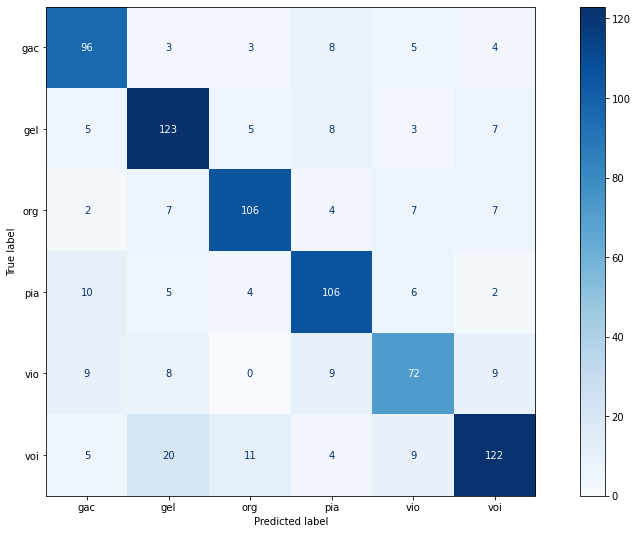

In [494]:
predicted_labels = grid.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )
print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


### Logistic Regression

In [495]:
tuning_params_logr={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
param_grid_logr = {}

for key,value in tuning_params_logr.items():
    hyperparam_key = "classify__" + key
    param_grid_logr[hyperparam_key] = value

#### Logistic Regression with all features

In [496]:
pipe = Pipeline([
        ('classify', LogisticRegression())
])

gs = GridSearchCV(pipe, param_grid=param_grid_logr, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [497]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 10.0, 'classify__penalty': 'l2'}
Best balanced accuracy score: 0.5462305282625134


Recall:  [0.56302521 0.43708609 0.51879699 0.62406015 0.5046729  0.51461988]
Recall Average:  0.5245700245700246
Precision:  [0.57264957 0.43708609 0.46308725 0.61481481 0.62068966 0.50285714]
Precision Average:  0.5245700245700246
F1-Score:  [0.56779661 0.43708609 0.4893617  0.61940299 0.55670103 0.50867052]
Accuracy: 0.52  , 427
Balanced accuracy: 0.53  , 0.5270435376489343
Number of samples: 814


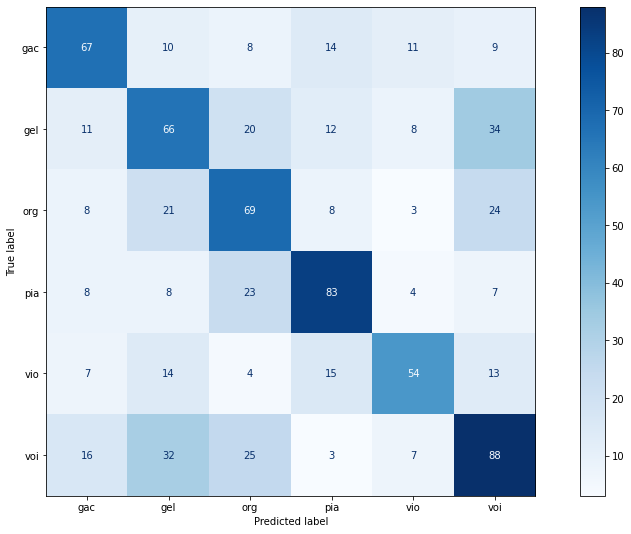

In [498]:
predicted_labels = gs.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )
print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


#### Logistic Regression with PCA

In [499]:
pipe = Pipeline([
        ('normalization', StandardScaler()),
        ('pca', PCA(n_components=0.85)), 
        ('classify', LogisticRegression())
])

gs = GridSearchCV(pipe, param_grid=param_grid_logr, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [500]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))
print('Best estimator explained variance: '+str(gs.best_estimator_.steps[1][1].explained_variance_))

Best parameters: {'classify__C': 1.0, 'classify__penalty': 'l2'}
Best balanced accuracy score: 0.48894431809927513
Best estimator explained variance: [7.90382561 2.56033086 1.96016412 1.58903288 1.43190959 1.35675322
 1.16214307 1.00763556 0.7958903  0.73952889 0.6228244  0.584781  ]


Recall:  [0.54621849 0.41721854 0.44360902 0.55639098 0.44859813 0.50292398]
Recall Average:  0.48525798525798525
Precision:  [0.56521739 0.42567568 0.41258741 0.5323741  0.52173913 0.48587571]
Precision Average:  0.48525798525798525
F1-Score:  [0.55555556 0.42140468 0.42753623 0.54411765 0.48241206 0.49425287]
Balanced Accuracy: 0.49  , 0.4858265229817707
Accuracy: 0.49  , 395
Number of samples: 814


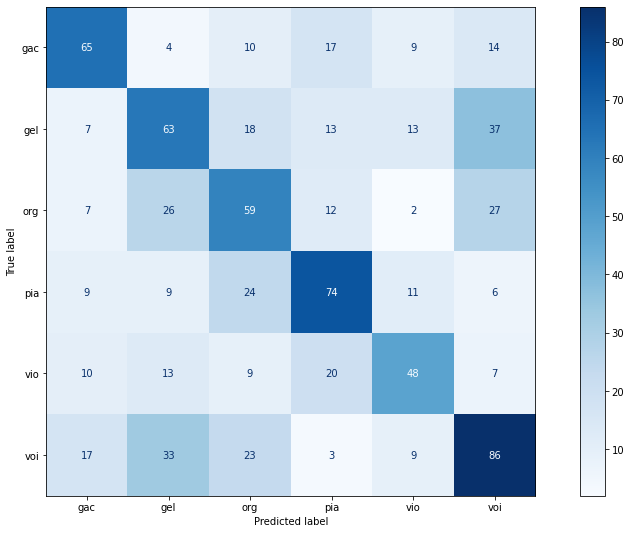

In [501]:
predicted_labels = gs.best_estimator_.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Balanced Accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


## Conclusion

which instrument the best

explanation which model

Best overall model so far: SVM with all features

In [502]:
print('Recall')
rec_score = recall_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))
print()
print('Precision')
rec_score = precision_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))


Recall
gac: 0.8403361344537815
gel: 0.7880794701986755
org: 0.8270676691729323
pia: 0.7293233082706767
vio: 0.6728971962616822
voi: 0.7134502923976608

Precision
gac: 0.7407407407407407
gel: 0.7345679012345679
org: 0.8333333333333334
pia: 0.7886178861788617
vio: 0.6666666666666666
voi: 0.7922077922077922


In [503]:
def predict_instrument(filename):

    # load model
    #svm_model = pickle.load(open('./model.pkl', 'rb'))

    # load scaler
    #scaler = pickle.load(open('./scaler.pkl','rb'))

    y, sr = librosa.load(filename, sr =44100)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    columns = ['rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
    for i in range(len(mfcc)):
        columns.append('mfcc' + str(i+1))

    rows = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]

    for i in mfcc:
        rows.append(np.mean(i))
    
    # create dataframe
    df_test = pd.DataFrame([rows])
    df_test.columns = columns

    # uniformly scale data
    test_transform = scaler.transform(df_test.values)

    return svm_model.predict(test_transform)
    

In [504]:
file_name = './IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'

In [505]:
file_name = './IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'vio'

In [506]:
file_name = './IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gac'

In [507]:
file_name = './IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gel'

In [508]:
file_name = './IRMAS-TestingData-Part1/Part1/00 - gold fronts-12.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'